# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 20
### <center> Yoshihiro Shirai


# Self-attention for time series modeling in Pytorch

- In this lecture we are going to see how to implement a self attention network in PyTorch for time series modeling

- We start with introducing Pytorch for simple feedforward neural networks

- We then explain the self-attention mechanism, and apply its applications to time series analysis

- Finally, we will look at an example on how to predict business cycles using self-attention and using GPU to optimize training time

- There is no reference for this lecture, but a nice paper you may consult is [here](https://arxiv.org/pdf/2207.00493)


# 1. Introduction to PyTorch

- We have so far used Keras for implementing neural networks

- Keras and PyTorch are both popular deep learning frameworks, but they cater to different needs:

    - Keras: A high-level API that runs on top of TensorFlow, designed for ease of use and rapid prototyping. It abstracts many complexities, making it beginner-friendly.

    - PyTorch: A lower-level framework that offers more flexibility and control, widely used in research and production. It provides dynamic computation graphs, making debugging and experimentation easier.

- If you prioritize simplicity and quick model development, Keras might be the better choice. If you need more customization and control, PyTorch is often preferred.

- Let's start with importing all the needed library


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset # will be used later for batching

- With PyTorch we need to move away from functional programming and pass to Object Oriented Programming

- This means that we define a class Model, which inherits all the properties and methods of PyTorch nn.Module class

- We then specify additional properties and methods for our Model class

- Specifically, we need two new functions:
    - The function __init__ is automatically called when an instance of the class Model is defined
        - It takes as inputs the dimensions of the neural network we want to define, which, in this case, has two hidden layers and one output layer
        - It then defines three properties of the Model class, which correspond to the three linear operations that need to be performed by the neural network
    - The function forward takes as input the actual input to the neural network
        - It then compute the first linear operation defined by Model.fc1, and applies to it the relu function (not that relu is a method of the torch.nn.functional class)
        - Similarly, it computes the second layer and the final output

In [2]:
class Model(nn.Module):
    ## input layer (4 dimensions) -> hidden layer 1 (128 dimensions) -> hidden layer 2 (64 dimensions) -> output layer (3 classes of iris flower species)
    ## The model is a simple feedforward neural network with two hidden layers.
    ## The first hidden layer has 128 neurons and the second hidden layer has 64 neurons.
    ## The activation function used is ReLU (Rectified Linear Unit).
    ## The output layer has 1 neuron, which is suitable for regression tasks.
    def __init__(self, in_features = 4, h1 = 8, h2 = 4, out_features = 3):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

- Next, let's see am example of how to use the model.

In [3]:
# Pick a manual seed for reproducibility
torch.manual_seed(41)
# Create an instance of the model
model = Model()
# Print the model architecture
print(model)
# Print the model summary
print("Model Summary:")
print("Input Layer: 4 features")
print("Hidden Layer 1: 8 neurons")
print("Hidden Layer 2: 4 neurons")
print("Output Layer: 3 classes (iris flower species)")

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=3, bias=True)
)
Model Summary:
Input Layer: 4 features
Hidden Layer 1: 8 neurons
Hidden Layer 2: 4 neurons
Output Layer: 3 classes (iris flower species)


We can test on the Iris dataset

In [4]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
my_df = pd.read_csv(url)
my_df['species']= my_df['species'].map({'setosa': 0.0, 'versicolor': 1.0, 'virginica': 2.0})
X = my_df.drop('species', axis=1).values
y = my_df['species'].values
X.shape, y.shape

((150, 4), (150,))

Next, we split the dataset into testing and training, and we convert it into PyTorch tensors.

- A tensor is nothing but a multidimensional array (a vector being a one dimensional array, and a matrix a two dimensional one)

In [14]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# In PyTorch, we need to convert the data into PyTorch tensors.
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
criterion = nn.CrossEntropyLoss() # Loss function for multi-class classification

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate of 0.01

num_epochs = 1000 # Number of epochs for training
losses = [] # List to store the loss values for each epoch
test_losses = []
# Training loop
for epoch in range(num_epochs):
    step_loss = []
    model.train() # Set the model to training mode
    for i, data in enumerate(X_train):
        # backpropagation
        optimizer.zero_grad() # Zero the gradients 
        y_pred = model(data)
        loss = criterion(y_pred, y_train[i])
        loss.backward() # Backward pass 
        optimizer.step() # Update the weights
        step_loss.append(loss)
        # print every 100 epochs
    loss = sum(step_loss) / len(step_loss) # Average loss for the epoch
    losses.append(loss.detach().numpy()) # Store the loss values

    with torch.no_grad(): # No need to compute gradients for the test set
        model.eval()
        step_test_loss = []
        for i, data in enumerate(X_test):
            y_test_pred = model(data) # Forward pass on the test set
            test_loss = criterion(y_test_pred, y_test[i]) # Compute the test loss
            step_test_loss.append(test_loss)
        test_loss = sum(step_test_loss) / len(step_test_loss)
        test_losses.append(test_loss.detach().numpy())

    # print every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}, Test Loss: {test_loss}')
    
    

Epoch [100/1000], Loss: 0.06736546009778976, Test Loss: 0.05579119548201561
Epoch [200/1000], Loss: 0.06707848608493805, Test Loss: 0.05535120517015457
Epoch [300/1000], Loss: 0.06681334972381592, Test Loss: 0.05479284003376961
Epoch [400/1000], Loss: 0.066587433218956, Test Loss: 0.05418817698955536
Epoch [500/1000], Loss: 0.06633898615837097, Test Loss: 0.05353178083896637
Epoch [600/1000], Loss: 0.06609421223402023, Test Loss: 0.05283326655626297
Epoch [700/1000], Loss: 0.06585775315761566, Test Loss: 0.05211428180336952
Epoch [800/1000], Loss: 0.06562957167625427, Test Loss: 0.05141037702560425
Epoch [900/1000], Loss: 0.06537527590990067, Test Loss: 0.05066568776965141
Epoch [1000/1000], Loss: 0.06513551622629166, Test Loss: 0.0499059297144413


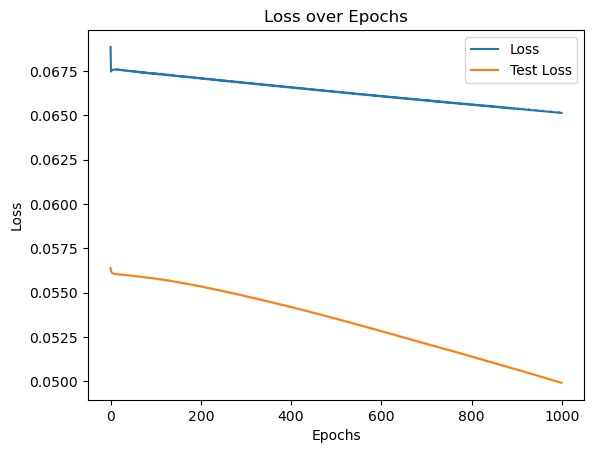

In [16]:
plt.plot(losses, label='Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

- The result is not so good:
    - We need to train for longer
    - Also, we initialized weights uniformly

- Next, we consider Xavier uniform initialization

- To speed up training, we will use batch gradient descent
    - This means that at each epoch we only go through one batch (with size set at 32 in this example)

- For larger models, we can also use GPU
    - This requires: ``` pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118```
    - It also requires compatibility between GPU and cuda version, for instance for NVIDIA GeForce RTX 4070 the cuda version needed is 11.8 or higher, and Pytorch version 2.0 or higher
    - Note that, since the model is so small, the advantage of using GPU is more than compensated by the need to send data back and forth to the right cpu/gpu formats
    - So using GPU is actually slower here
    - As a rule of thumb:
        - Small Models: A simple feedforward network with 2-3 layers and <100 neurons per layer will not fully utilize the GPU.
        - Medium Models: A CNN with 5-10 convolutional layers and 32-128 filters per layer can benefit from GPU acceleration.
        - Large Models: Transformers, ResNet, or other deep architectures with millions of parameters are ideal for GPUs.
    - In any case, the code below can be used for GPU as well for your reference

In [18]:
# Check if GPU is available and set the device
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
print(torch.__version__)


True
1
NVIDIA GeForce RTX 4070 Laptop GPU
2.7.0+cu118


In [8]:
class ModelX(nn.Module):
    ## input layer (4 dimensions) -> hidden layer 1 (128 dimensions) -> hidden layer 2 (64 dimensions) -> output layer (3 classes of iris flower species)
    ## The model is a simple feedforward neural network with two hidden layers.
    ## The first hidden layer has 128 neurons and the second hidden layer has 64 neurons.
    ## The activation function used is ReLU (Rectified Linear Unit).
    ## The output layer has 1 neuron, which is suitable for regression tasks.
    def __init__(self, in_features = 4, h1 = 8, h2 = 4, out_features = 3):
        super(ModelX, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self._init_weights()
        # Initialize weights using Xavier uniform distribution

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Using device: {device}")

# Pick a manual seed for reproducibility
torch.manual_seed# Create an instance of the model
modelX = ModelX().to(device)
optimizer = torch.optim.Adam(modelX.parameters(), lr=0.001)

Using device: cpu


In [20]:
# Move the data to the GPU
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# To make full use of the GPU, we will need to do batch gradient descent
# will use DataLoader to create batches of data.

train_dataset = TensorDataset(X_train, y_train) # Create a TensorDataset from the training data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Create a DataLoader for the training data
test_dataset = TensorDataset(X_test, y_test) # Create a TensorDataset from the test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Create a DataLoader for the test data


# Training loop
num_epochs = 10000  # Number of epochs for training
losses = []  # List to store the loss values for each epoch
test_losses = []

for epoch in range(num_epochs):
    step_loss = []
    modelX.train()  # Set the model to training mode
    for data, target in train_loader:
        # Backpropagation
        optimizer.zero_grad()  # Zero the gradients
        y_pred = modelX(data)
        loss = criterion(y_pred, target)
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        step_loss.append(loss)

    # Average loss for the epoch
    loss = sum(step_loss) / len(step_loss)
    losses.append(loss.detach().cpu().numpy())  # Store the loss values (move to CPU for storage)

    # Evaluate on the test set
    with torch.no_grad():  # No need to compute gradients for the test set
        modelX.eval()
        step_test_loss = []
        for data, target in test_loader:
            y_test_pred = modelX(data)  # Forward pass on the test set
            test_loss = criterion(y_test_pred, target)  # Compute the test loss
            step_test_loss.append(test_loss)
        test_loss = sum(step_test_loss) / len(step_test_loss)
        test_losses.append(test_loss.detach().cpu().numpy())  # Move to CPU for storage

    # Print every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}, Test Loss: {test_loss}")

Epoch [1000/10000], Loss: 0.23762255907058716, Test Loss: 0.23034386336803436
Epoch [2000/10000], Loss: 0.10529082268476486, Test Loss: 0.10451038926839828
Epoch [3000/10000], Loss: 0.07338607311248779, Test Loss: 0.07273206859827042
Epoch [4000/10000], Loss: 0.058910589665174484, Test Loss: 0.060312263667583466
Epoch [5000/10000], Loss: 0.05841144919395447, Test Loss: 0.053549692034721375
Epoch [6000/10000], Loss: 0.054242756217718124, Test Loss: 0.04869992658495903
Epoch [7000/10000], Loss: 0.055115699768066406, Test Loss: 0.0447271429002285
Epoch [8000/10000], Loss: 0.05152827501296997, Test Loss: 0.04146949574351311
Epoch [9000/10000], Loss: 0.04939286410808563, Test Loss: 0.03879891708493233
Epoch [10000/10000], Loss: 0.049463097006082535, Test Loss: 0.03648466616868973


- Training with batch gradient descent is 10x faster

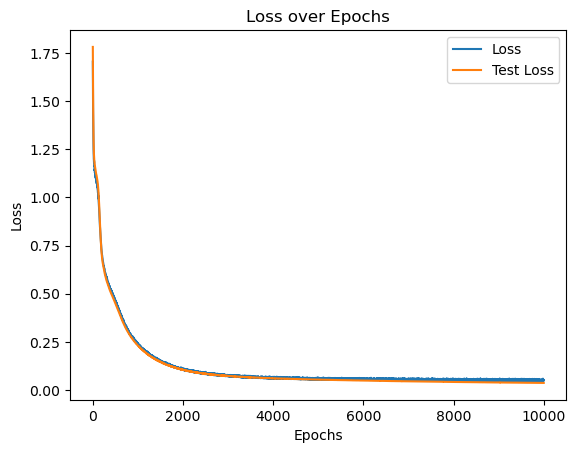

In [21]:
# Plotting the loss values
plt.plot(losses, label='Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# 2. Self-attention mechanism

The self-attention mechanism is a foundational concept in modern deep learning architectures, particularly in models like Transformers. It allows a model to dynamically focus on different parts of the input sequence when making predictions, enabling it to capture both local and global dependencies effectively.

## 2.1 Key Components of Self-Attention

### 2.1.1 Self-attention mechanism
- Suppose the input sequence consists of $n$ elements, each represented as a vector of dimension $d$. The input can be written as: 
$$
X = [x_1, x_2, \dots, x_n] \in \mathbb{R}^{n \times d}
$$

- For each input vector $x_i$, the self-attention mechanism computes three vectors:
    - Query $Q_i$: Represents the element for which attention is being calculated.
    - Key $K_i$: Represents the elements being compared to the query.
    - Value $V_i$: Represents the information to be aggregated based on the attention scores.

- These vectors are computed using learned weight matrices: $Q = XW_Q, \quad K = XW_K, \quad V = XW_V$, where   
    - $W_Q, W_K, W_V \in \mathbb{R}^{d \times d_k}$ are the weight matrices,
    - $d_k$ is the dimensionality of the query, key, and value vectors.

- The attention score between two elements $x_i$ and $x_j$ is computed as the scaled dot product of their query and key vectors: 
$$
\text{Score}(x_i, x_j) = \frac{Q_i \cdot K_j^\top}{\sqrt{d_k}}
$$

- The scaling factor $\sqrt{d_k}$ prevents the dot product from growing too large, which could lead to vanishing gradients during raining.

- The attention scores are passed through a softmax function to compute the attention weights, ensuring they sum to 1: 
$$
\alpha_{ij} = \text{softmax}\left(\frac{Q_i \cdot K_j^\top}{\sqrt{d_k}}\right) = \frac{\exp\left(\frac{Q_i \cdot K_j^\top}{\sqrt{d_k}}\right)}{\sum_{j=1}^n \exp\left(\frac{Q_i \cdot K_j^\top}{\sqrt{d_k}}\right)}$$

- The output for each element $x_i$ is computed as a weighted sum of the value vectors, where the weights are the attention scores: 
$$
\text{Output}_i = \sum_{j=1}^n \alpha_{ij} V_j
$$

- This operation is performed for all elements in the sequence, resulting in the final output matrix: 
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

### 2.1.2 Multi-Head Attention

- To enhance the model's ability to focus on different parts of the sequence simultaneously, the self-attention mechanism is extended to multi-head attention:

- The input is projected into multiple sets of $(Q, K, V)$ vectors (one for each attention head).

- Each head computes its own attention output independently.

- The outputs of all heads are concatenated and projected back into the original space:
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \dots, \text{head}_h)W_O
$$

- In the above equation, $W_O \in \mathbb{R}^{hd_k \times d}$ is the output projection matrix, and $h$ is the number of attention heads.

### 2.1.3 Masking in Time Series Self-Attention

- The self-attention mechanism computes attention scores for all pairs of time steps in the input sequence.

- In time series modeling, it is crucial to ensure that predictions for a given time step are not influenced by future time steps. This is because future data points are not available during prediction.

- To address this, masking is applied in the self-attention mechanism.

- Without masking, the model could "cheat" by using information from future time steps to predict the current time step, which violates the causality constraint in time series forecasting.

- A mask is a matrix that specifies which elements in the attention computation should be ignored.

- For a sequence of length $n$, the mask is typically a lower triangular matrix: 
$$
\text{Mask} = \begin{bmatrix} 1 & 0 & 0 & \cdots & 0 \\ 1 & 1 & 0 & \cdots & 0 \\ 1 & 1 & 1 & \cdots & 0 \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & 1 & 1 & \cdots & 1 \end{bmatrix}
$$

- Here, a value of 1 indicates that the corresponding element can be attended to, while 0 indicates that it should be ignored.

- During the computation of attention scores, the mask is applied to the scaled dot product $QK^\top$ before the softmax operation.

- Specifically, masked positions are set to a very large negative value (e.g., $-\infty$) so that their softmax output becomes effectively zero: 
$$
\text{Masked Scores} = \begin{cases} \frac{QK^\top}{\sqrt{d_k}}, & \text{if allowed by the mask} \\ -\infty, & \text{if masked} \end{cases}
$$

- This ensures that the model only attends to past and current time steps.

- After applying the mask, the softmax function is computed as usual: 
$$
\alpha_{ij} = \frac{\exp(\text{Masked Scores}_{ij})}{\sum_{j=1}^n \exp(\text{Masked Scores}_{ij})}
$$

- Masked positions contribute nothing to the final attention weights.


### 2.1.4 Creating sparse attention layers

- In financial times series, masks are also used to create a sparse attention layer, which accelerates computation and improve the focus of the attention layer

- For instance, we could decide to focus only one the last two days of data to predict the next one

- This means that, with, say $n=16$, the mask becomes
$$
\text{Mask} = 
\begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
                \end{bmatrix}
$$

- Even more sparse masks can be used to accelerate computation time, such as
$$
\text{Mask} = 
\begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
                \end{bmatrix}
$$

# 3 Fitting a self-attention architecture 

- Let us look at an example on how we can define and train a neural net to make forecasts based on a time series

- We will consider the "Daily Minimum Temperatures in Melbourne" dataset, which is composed of 10 years of daily observations of temperaturs in Melbourn
    - Note that, to justify the use of selfattention mechanism and avoid overfitting we need a meaningful dataset to fit

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset # will be used later for batching

# Load the Dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url, usecols=[1], header=0)
print(data.head())
data = data.values.astype(float)
print(data.shape)


   Temp
0  20.7
1  17.9
2  18.8
3  14.6
4  15.8
(3650, 1)


- Next, we process the data as usual

- Note that in PyTorch we can use the torch.utils.data.Dataset class

- It is used to define custom datasets for training and testing machine learning models

- By subclassing Dataset, you can create your own dataset class to handle data loading, preprocessing, and augmentation

- Some of its Key features are as follows:
    - You can define how data is loaded and processed by overriding the __len__ and __getitem__ methods. 
    - A Dataset object can be passed to a DataLoader, which handles batching, shuffling, and parallel data loading.
    - It allows you to work with data in various formats, such as images, text, or time series, by implementing custom logic in the dataset class.

- To implement a subclass of Dataset, you need to implement ```__len__``` and ```__getitem__``` which, respectively, give the total number of samples in the dataset and retrieve a single data sample at a given index
    - The ```__getitem__``` function is automatically called when one wants to access a certain datapoint (see e.g. the code below defining the train_dataset array)

In [2]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Create a dataset for time series forecasting
class TimeSeriesDataset(Dataset): 
    def __init__(self, data, seq_length, device="cpu"): 
        self.data = torch.FloatTensor(data).to(device)
        self.seq_length = seq_length
        self.device = device

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        # Perform slicing on the CPU and then move to the GPU
        x = self.data[index:index + self.seq_length].cpu()
        y = self.data[index + self.seq_length].cpu()
        return x.to(self.device).squeeze(-1), y.to(self.device)

seq_length = 12  # Use the last 12 months to predict the next month
dataset = TimeSeriesDataset(data, seq_length)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = TimeSeriesDataset(data, seq_length, device=device)

# Chronological split to preserve causality
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

# DataLoader generates batches of training data (note, shuffle=True, and causality is preserved based on how get_item is defined)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
# It is also a good idea to construct batches for the test set so we are consistent with what we do in the training, but we do not need to shuffle the test set.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # DataLoader for testing data


- We next create the SelfAttention class, which implements a self-attention architecture with 1 head (unless otherwise specified)

- This is easily achieved in PyTorch using the nn.MultiheadAttention module

- A causal mask is also easily added using torch's triu function, which creates a tridiagonal matrix (note: Torch requires the masked position to be marked as True, rather than False)

- We also modify this mask to specify the lookback period - e.g., one may want to only look back at, say, 30 days of previous data to predict the next one

- Other masks can be created and implemented equally easily in Torch - this is an example of the flexibility of this library compared to Keras

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lookback_period=None,  dropout_rate=0.1):
        super(SelfAttention, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Project input to hidden_dim
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Project back to output_dim
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout for regularization
        self.lookback_period = lookback_period
        self._init_weights()

    def _init_weights(self, scale=2.0):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Initialize Linear layers with Xavier uniform distribution
                torch.nn.init.xavier_uniform_(m.weight)
                m.weight = torch.nn.Parameter(scale * m.weight.data)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, nn.MultiheadAttention):
                # Initialize MultiheadAttention weights (Q, K, V, and output projection)
                torch.nn.init.xavier_uniform_(m.in_proj_weight)
                m.in_proj_weight = torch.nn.Parameter(scale * m.in_proj_weight.data)
                torch.nn.init.xavier_uniform_(m.out_proj.weight)
                m.out_proj.weight = torch.nn.Parameter(scale * m.out_proj.weight.data)
                if m.in_proj_bias is not None:
                    torch.nn.init.zeros_(m.in_proj_bias)
                if m.out_proj.bias is not None:
                    torch.nn.init.zeros_(m.out_proj.bias)


    def forward(self, x):
        # x shape: (batch_size, seq_length)
        x = self.fc1(x)  # Linear layer
        x = F.relu(x)  # Apply ReLU activation

        # Reshape x to (batch_size, seq_length, hidden_dim) for MultiheadAttention
        x = x.unsqueeze(1)  # Add a sequence dimension if missing
        seq_length = x.size(1)

        # Create a lookback mask
        if self.lookback_period:
            mask = torch.ones(seq_length, seq_length, device=x.device).triu(diagonal=1)
            mask[:, :seq_length - self.lookback_period] = float('-inf')  # Restrict to lookback_period
        else:
            mask = torch.triu(torch.ones(seq_length, seq_length, device=x.device), diagonal=1).bool()

        # Apply the mask in the attention layer
        x, _ = self.attention(x, x, x, attn_mask=mask)

        # Use the output of the last time step for prediction
        x = x.squeeze(1)  # Remove the sequence dimension
        x = self.fc2(x)  # Project to output_dim
        return x

Next, we define an instance of the SelfAttention class, the minimization criterion and the optimizer

In [10]:
# Model, Loss, and Optimizer
input_dim = seq_length
hidden_dim = 64
output_dim = 1
lookback_period = None  # Look back only the last 30 days
model = SelfAttention(input_dim=seq_length, hidden_dim=64, output_dim=1, lookback_period=lookback_period).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


The training loop is similar as before

- Note that the train loss now goes up and down, can you explain why?

In [11]:
# Training Loop
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    #scheduler.step()

Epoch 10/100, Train Loss: 0.0116, Test Loss: 0.0102
Epoch 20/100, Train Loss: 0.0098, Test Loss: 0.0082
Epoch 30/100, Train Loss: 0.0096, Test Loss: 0.0074
Epoch 40/100, Train Loss: 0.0102, Test Loss: 0.0074
Epoch 50/100, Train Loss: 0.0108, Test Loss: 0.0094
Epoch 60/100, Train Loss: 0.0100, Test Loss: 0.0076
Epoch 70/100, Train Loss: 0.0105, Test Loss: 0.0213
Epoch 80/100, Train Loss: 0.0124, Test Loss: 0.0120
Epoch 90/100, Train Loss: 0.0099, Test Loss: 0.0118
Epoch 100/100, Train Loss: 0.0098, Test Loss: 0.0076


This is because at each epoch the network sees a different batch, so the error will naturally fluctuate

Plotting the losses reveals that most of what can be learned is in the first few epochs, and the learning curves stabilize by epoch 20

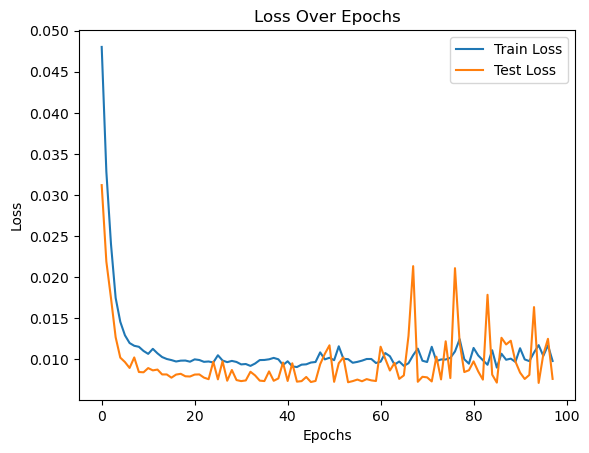

Forecasted value: 12.76


In [12]:
# Plot the Loss
plt.plot(train_losses[2:], label="Train Loss")
plt.plot(test_losses[2:], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

# Forecasting Example
model.eval()
with torch.no_grad():
    # Ensure last_sequence has the correct shape (1, seq_length)
    last_sequence = torch.FloatTensor(data[-seq_length:].flatten()).unsqueeze(0).to(device)
    forecast = model(last_sequence)
    forecast = scaler.inverse_transform(forecast.cpu().numpy())
    print(f"Forecasted value: {forecast[0][0]:.2f}")

However, this model performs better than a naive one, so something was learned

In [13]:
# Calculate percentage error for model and the naive baseline
percentage_errors_model = []
percentage_errors_baseline = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        # Model prediction
        y_pred = model(x)
        y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
        y_actual = scaler.inverse_transform(y.cpu().numpy())
        
        # Baseline prediction (next day = today's temperature)
        y_baseline = x[:, -1].cpu().numpy()  # Last value in the input sequence
        y_baseline = scaler.inverse_transform(y_baseline.reshape(-1, 1))
        
        # Calculate percentage errors
        error_model = abs((y_pred.flatten() - y_actual.flatten()) / y_actual.flatten()) * 100
        error_baseline = abs((y_baseline.flatten() - y_actual.flatten()) / y_actual.flatten()) * 100
        
        percentage_errors_model.extend(error_model)
        percentage_errors_baseline.extend(error_baseline)

# Calculate average percentage errors
average_error_model = sum(percentage_errors_model) / len(percentage_errors_model)
average_error_baseline = sum(percentage_errors_baseline) / len(percentage_errors_baseline)

# Print the average errors
print(f"Average Percentage Error (Model): {average_error_model:.2f}%")
print(f"Average Percentage Error (Baseline): {average_error_baseline:.2f}%")


Average Percentage Error (Model): 20.26%
Average Percentage Error (Baseline): 21.26%
